<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
# ## install finrl library
# !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.neo_finrl.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/google/home/ammarh/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [4]:
# from config.py start_date is a string
config.START_DATE

'2009-01-01'

In [5]:
# from config.py end_date is a string
config.END_DATE

'2021-10-31'

In [6]:
print(config.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [7]:
df = YahooDownloader(start_date = '2009-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [10]:
df.shape

(94331, 8)

In [11]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.778781,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,45.615871,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.618542,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,32.475811,7117200,CAT,4


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3229, 8)
Successfully added vix
Successfully added turbulence index


In [13]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [14]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.778781,746015200.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,2.778781,2.778781,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,45.615871,6547900.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,45.615871,45.615871,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.618542,10955700.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,15.618542,15.618542,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,33.941101,33.941101,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,32.475811,7117200.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,32.475811,32.475811,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.421840,40980600.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,12.421840,12.421840,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,45.650551,13695900.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,45.650551,45.650551,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597498,9796600.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,20.597498,20.597498,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,71.965553,14088500.0,4.0,0.0,3.003272,2.671566,100.0,66.666667,100.0,71.965553,71.965553,39.189999,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2009-01-01 to 2020-07-01
## Trade data split: 2020-07-01 to 2021-10-31

In [16]:
train = data_split(processed_full, '2009-01-01','2020-07-01')
trade = data_split(processed_full, '2020-07-01','2021-10-31')
print(len(train))
print(len(trade))

83897
9744


In [17]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2892,2020-06-30,UNH,288.570007,296.450012,287.660004,289.569763,2932900.0,1.0,-0.019598,305.819483,272.941238,52.413044,-25.789716,1.846804,289.815176,282.752199,30.43,12.918749
2892,2020-06-30,V,191.490005,193.750000,190.160004,191.412430,9040100.0,1.0,1.052499,199.454076,185.696445,53.021032,-51.516818,2.013358,192.162882,182.320811,30.43,12.918749
2892,2020-06-30,VZ,54.919998,55.290001,54.360001,51.604496,17414800.0,1.0,-0.447764,55.232496,49.916927,48.097039,-50.926686,8.508886,52.255363,52.718948,30.43,12.918749
2892,2020-06-30,WBA,42.119999,42.580002,41.759998,39.892536,4782100.0,1.0,-0.085830,43.544547,37.287956,48.830183,-14.445192,1.500723,39.994175,39.789724,30.43,12.918749
2892,2020-06-30,WMT,119.220001,120.129997,118.540001,117.465691,6836400.0,1.0,-0.896829,120.856468,114.824140,48.159687,-69.901592,3.847271,119.150817,121.108866,30.43,12.918749


In [18]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,90.151405,110737200.0,2.0,3.022879,92.953797,80.400062,62.807115,107.487540,29.730532,84.164182,77.930892,28.620001,53.0683
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,244.159134,6575800.0,2.0,3.697038,236.273235,203.551999,61.279648,271.769158,46.806139,218.441970,219.532869,28.620001,53.0683
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.579552,3301000.0,2.0,-0.391247,111.015317,88.229331,48.504818,-66.339671,3.142448,97.765433,91.181247,28.620001,53.0683
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.0683
0,2020-07-01,CAT,129.380005,129.399994,125.879997,121.818474,2807800.0,2.0,1.284936,131.887572,114.449380,52.865416,35.546903,14.457404,120.567698,114.745770,28.620001,53.0683


In [19]:
config.TECHNICAL_INDICATORS_LIST

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [20]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 291


In [21]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [23]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [24]:
agent = DRLAgent(env = env_train)

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


In [25]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [26]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

Logging to tensorboard_log/a2c/a2c_1
--------------------------------------
| time/                 |            |
|    fps                | 60         |
|    iterations         | 100        |
|    time_elapsed       | 8          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -0.213     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -52        |
|    reward             | 0.07596916 |
|    std                | 1.01       |
|    value_loss         | 2.05       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 79         |
|    iterations         | 200        |
|    time_elapsed       | 12         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | -

### Model 2: DDPG

In [28]:
# %%capture
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [29]:
%%capture
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

### Model 3: PPO

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

Logging to tensorboard_log/ppo/ppo_1
-----------------------------------
| time/              |            |
|    fps             | 100        |
|    iterations      | 1          |
|    time_elapsed    | 20         |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | 0.29581577 |
-----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 97          |
|    iterations           | 2           |
|    time_elapsed         | 42          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017488813 |
|    clip_fraction        | 0.223       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.0181     |
|    learning_rate        | 0.00025     |
|    loss                 | 5.55        |
|    n_updates            | 10          |
|    poli

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

Logging to tensorboard_log/td3/td3_1
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 32       |
|    time_elapsed    | 356      |
|    total_timesteps | 11572    |
| train/             |          |
|    actor_loss      | 60.9     |
|    critic_loss     | 275      |
|    learning_rate   | 0.001    |
|    n_updates       | 8679     |
|    reward          | 3.542489 |
---------------------------------


### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cpu device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

Logging to tensorboard_log/sac/sac_1
day: 2892, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 4460802.12
total_reward: 3460802.12
total_cost: 7486.56
total_trades: 44299
Sharpe: 0.865


## Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [30]:
data_risk_indicator = processed_full[(processed_full.date<'2020-07-01') & (processed_full.date>='2009-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [31]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [32]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [33]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.567956
std        43.790780
min         0.000000
25%        14.962697
50%        24.124092
75%        39.162233
max       652.504069
Name: turbulence, dtype: float64

In [34]:
insample_risk_indicator.turbulence.quantile(0.996)

276.4502671101018

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [35]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [36]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,90.151405,110737200.0,2.0,3.022879,92.953797,80.400062,62.807115,107.487540,29.730532,84.164182,77.930892,28.620001,53.0683
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,244.159134,6575800.0,2.0,3.697038,236.273235,203.551999,61.279648,271.769158,46.806139,218.441970,219.532869,28.620001,53.0683
0,2020-07-01,AXP,95.250000,96.959999,93.639999,92.579552,3301000.0,2.0,-0.391247,111.015317,88.229331,48.504818,-66.339671,3.142448,97.765433,91.181247,28.620001,53.0683
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.0683
0,2020-07-01,CAT,129.380005,129.399994,125.879997,121.818474,2807800.0,2.0,1.284936,131.887572,114.449380,52.865416,35.546903,14.457404,120.567698,114.745770,28.620001,53.0683


In [38]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [39]:
df_account_value.shape

(336, 2)

In [40]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.346069e+06
332,2021-10-25,1.349499e+06
333,2021-10-26,1.348008e+06
334,2021-10-27,1.336730e+06
335,2021-10-28,1.349311e+06


In [41]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,100,0,0,100,0,100,100,100,0,...,100,100,100,0,100,0,100,0,100,0
2020-07-02,0,100,0,0,100,0,100,100,100,0,...,100,100,100,0,100,0,100,0,100,0
2020-07-06,0,100,0,0,100,0,100,100,100,0,...,100,100,100,0,100,0,100,0,100,0
2020-07-07,0,100,0,0,100,0,100,100,100,0,...,100,100,100,0,100,0,100,0,100,0
2020-07-08,0,100,0,0,100,0,100,100,100,0,...,100,100,100,0,100,0,100,0,100,0


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [42]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.251941
Cumulative returns     0.349311
Annual volatility      0.143238
Sharpe ratio           1.645493
Calmar ratio           3.182699
Stability              0.874070
Max drawdown          -0.079160
Omega ratio            1.311243
Sortino ratio          2.452559
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.082546
Daily value at risk   -0.017111
dtype: float64


In [43]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [ ]:
df_account_value.loc[0,'date']

'2020-07-01'

In [ ]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,25.194%
Cumulative returns,34.931%
Annual volatility,14.324%
Sharpe ratio,1.65
Calmar ratio,3.18
Stability,0.87
Max drawdown,-7.916%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.92,2020-09-02,2020-10-28,2020-11-09,49
1,6.33,2021-08-16,2021-09-30,NaT,NaN
2,4.91,2021-05-07,2021-06-18,2021-07-12,47
3,3.50,2020-07-22,2020-07-31,2020-08-10,14
4,3.31,2021-01-20,2021-01-29,2021-02-04,12


/usr/local/google/home/ammarh/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.09%,-3.32%,3.87%


/usr/local/google/home/ammarh/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


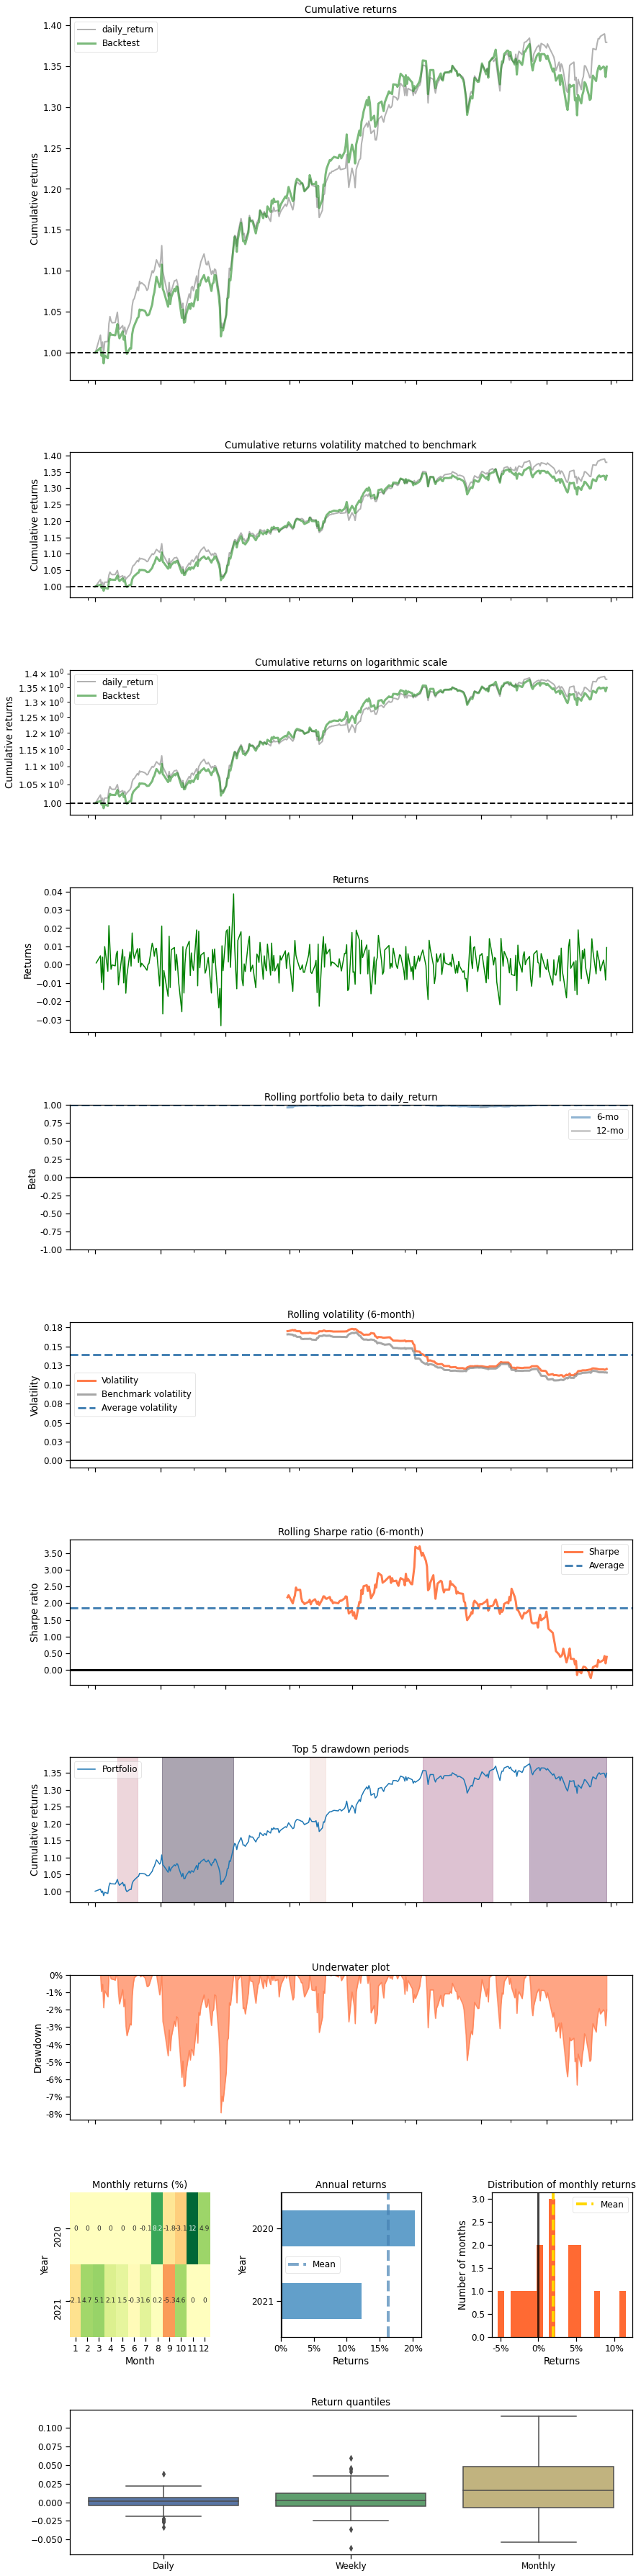

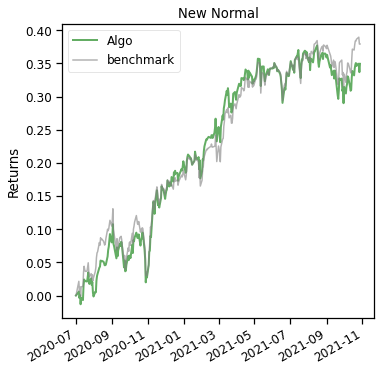

In [44]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])